<a href="https://colab.research.google.com/github/shovanpaul48/DeepSteganography/blob/master/SteganoGraphy3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import pickle

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display


%load_ext autoreload
%autoreload 2

In [2]:
(x, y), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 16s 0us/step


In [3]:
x = x.astype(np.float32)
x_test = x_test.astype(np.float32)

In [4]:
# for when payload is grayscale
# payload_train = np.mean(x, axis=-1)[:5000, :, :, np.newaxis]

# for when payload is rgb
payload_train = x[:5000]

host_train = x[np.random.choice(np.arange(x.shape[0]), size=payload_train.shape[0])][:5000]

# for when payload is grayscale
payload_test = np.mean(x_test, axis=-1)[:500, :, :, np.newaxis]

# for when payload is rgb
payload_test = x[:500]

host_test = x_test[np.random.choice(np.arange(x_test.shape[0]), size=payload_test.shape[0])][:500]

In [5]:
# Instantiate the Dataset class
train_dataset = tf.data.Dataset.from_tensor_slices((payload_train, host_train))

In [6]:
# Normalization function
def normalize(payload, host):
    payload = tf.image.per_image_standardization(payload)
    host = tf.image.per_image_standardization(host)
    return payload, host

# Adding shuffle, normalization and batching operations to the dataset object
train_dataset = train_dataset.map(normalize).shuffle(5000).batch(256, drop_remainder=True)

In [7]:
# Instantiate the test Dataset class
test_dataset = tf.data.Dataset.from_tensor_slices((payload_test, host_test))
test_dataset = (test_dataset.map(normalize).batch(128, drop_remainder=True)).shuffle(500)

In [8]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input

In [9]:
tf.keras.backend.set_floatx('float32')
tf.keras.backend.floatx()

'float32'

In [10]:
# encoder.py
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Concatenate, Input

class EncoderNetwork:
    def __init__(self, carrier_shape=(32, 32, 3), payload_shape=(32, 32, 1)):
        
#         super(EncoderModel, self).__init__()
        self.carrier_shape = carrier_shape
        self.payload_shape = payload_shape
        
    def _init_branch_payload(self, payload):

        self.branch__payload_conv_1 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal', input_shape=self.payload_shape)(payload)
        self.branch__payload_conv_2 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch__payload_conv_1)
        self.branch__payload_conv_3 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch__payload_conv_2)
        self.branch__payload_conv_4 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch__payload_conv_3)
        self.branch__payload_conv_5 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch__payload_conv_4)
        self.branch__payload_conv_6 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch__payload_conv_5)
        self.branch__payload_conv_7 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch__payload_conv_6)
        
        self.payload_tensors = [self.branch__payload_conv_1, self.branch__payload_conv_2,\
                                self.branch__payload_conv_3, self.branch__payload_conv_4, self.branch__payload_conv_5,\
                                self.branch__payload_conv_6, self.branch__payload_conv_7]
    
    def _init_branch_carrier(self, carrier):
        
        self.branch_carrier_conv_1 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(carrier)
        self.branch_carrier_concat_1 = Concatenate()([self.branch_carrier_conv_1, self.branch__payload_conv_1])
        
        self.branch_carrier_conv_2 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch_carrier_concat_1)
        
        self.branch_carrier_conv_3 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch_carrier_conv_2)
        self.branch_carrier_concat_2 = Concatenate()([self.branch_carrier_conv_3, self.branch__payload_conv_3])
        
        self.branch_carrier_conv_4 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch_carrier_concat_2)
        
        self.branch_carrier_conv_5 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch_carrier_conv_4)
        self.branch_carrier_concat_3 = Concatenate()([self.branch_carrier_conv_5, self.branch__payload_conv_5])
        
        self.branch_carrier_conv_6 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch_carrier_concat_3)
        
        self.branch_carrier_conv_7 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch_carrier_conv_6)
        self.branch_carrier_concat_4 = Concatenate()([self.branch_carrier_conv_7, self.branch__payload_conv_7])
        
        self.branch_carrier_conv_8 = Conv2D(16, 1, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch_carrier_concat_4)
        self.branch_carrier_conv_9 = Conv2D(8, 1, padding='same', activation='relu', kernel_initializer='he_normal')(self.branch_carrier_conv_8)
        self.encoded_output = Conv2D(3, 1, padding='same', kernel_initializer='he_normal', name='encoded_output')(self.branch_carrier_conv_9)
        
        self.carrier_tensors = [self.branch_carrier_conv_1, self.branch_carrier_concat_1,\
                               self.branch_carrier_conv_2, self.branch_carrier_conv_3, self.branch_carrier_concat_2,\
                               self.branch_carrier_conv_4, self.branch_carrier_conv_5, self.branch_carrier_concat_3,\
                               self.branch_carrier_conv_6, self.branch_carrier_conv_7, self.branch_carrier_concat_4,\
                               self.branch_carrier_conv_8, self.branch_carrier_conv_9, self.encoded_output]
    
    def get_network(self, carrier, payload):
        
        self._init_branch_payload(payload)
        self._init_branch_carrier(carrier)
        
        return self.encoded_output

In [11]:
# decoder.py

from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Concatenate, Input

class DecoderNetwork:
    def __init__(self, target_image_shape = (32, 32, 1)):
#         super(DecoderModel, self).__init__()
        self.target_image_shape = target_image_shape
        
    def _init_network(self, input_):

        self.conv_1 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(input_)
        self.conv_2 = Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.conv_1)
        self.conv_3 = Conv2D(8, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.conv_2)
        self.conv_4 = Conv2D(8, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.conv_3)
        self.conv_5 = Conv2D(3, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.conv_4)
        self.conv_6 = Conv2D(3, 3, padding='same', activation='relu', kernel_initializer='he_normal')(self.conv_5)
        self.decoded_output = Conv2D(self.target_image_shape[-1], self.target_image_shape[-1], padding='same', activation='relu', kernel_initializer='he_normal', name='decoded_output')(self.conv_6)
        
        self.decoder_tensors = [self.conv_1, self.conv_2,\
                                self.conv_3, self.conv_4, self.conv_5,\
                                self.conv_6, self.decoded_output]
    
    def get_network(self, encoder_output):
        
        self._init_network(encoder_output)

        return self.decoded_output

In [12]:
carrier_image_shape=(32, 32, 3)
payload_image_shape=(32, 32, 3)

encoder_network = EncoderNetwork(carrier_shape=carrier_image_shape, payload_shape=payload_image_shape)
decoder_network = DecoderNetwork(target_image_shape=payload_image_shape)

In [13]:
input_carrier = Input(shape=carrier_image_shape, name='input_carrier')
input_payload = Input(shape=payload_image_shape, name='input_payload')

In [14]:
encoded_output = encoder_network.get_network(input_carrier, input_payload)
decoded_output = decoder_network.get_network(encoded_output)

In [15]:
steganography_model = Model(inputs=[input_carrier, input_payload], outputs=[encoded_output, decoded_output])

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(steganography_model, show_shapes=True)

In [ ]:
steganography_model.summary()

In [18]:
# Defining Loss Function

@tf.function
def loss_function(payload, host, encoder_output, decoder_output):
    
    loss = tf.math.reduce_mean(tf.math.squared_difference(payload, decoder_output)\
                           + tf.math.squared_difference(host, encoder_output))
        
    return loss


In [19]:
def custom_loss(input_):
    def loss(y_true, y_pred):
        return tf.math.reduce_mean(tf.math.squared_difference(y_true, y_pred))
    return loss             

In [20]:
optimizer = tf.keras.optimizers.Adam(0.0001)

In [21]:
a = None
for payload, host in train_dataset.batch(5000):
    a = host
    break

In [23]:
test_loss = tf.keras.metrics.Mean(name='test_loss')
train_loss = tf.keras.metrics.Mean(name='train_loss')

@tf.function
def train_step(payload, host):
    with tf.GradientTape() as tape:
        encoded_host, decoded_payload = steganography_model([host, payload])
        loss = loss_function(payload, host, encoded_host, decoded_payload)
        train_loss(loss)
    gradients = tape.gradient(loss, steganography_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, steganography_model.trainable_variables))
    
    train_host_psnr = tf.reduce_mean(tf.image.psnr(host, encoded_host, 18))
    train_payload_psnr = tf.reduce_mean(tf.image.psnr(payload, decoded_payload, 18))
    
    return train_host_psnr, train_payload_psnr



@tf.function
def test_step(payload, host):
    encoded_host, decoded_payload = steganography_model([host, payload])
    t_loss = loss_function(payload, host, encoded_host, decoded_payload)
    test_loss(t_loss)
    
    test_host_psnr = tf.reduce_mean(tf.image.psnr(host, encoded_host, 18))
    test_payload_psnr = tf.reduce_mean(tf.image.psnr(payload, decoded_payload, 18))
    
    return test_host_psnr, test_payload_psnr

EPOCHS = 5
SUMMARY_DIR = './summary'


In [25]:
test_loss = tf.keras.metrics.Mean(name='test_loss') 
train_loss = tf.keras.metrics.Mean(name='train_loss')

@tf.function
def train_step(payload, host):
    with tf.GradientTape() as tape:
        encoded_host, decoded_payload = steganography_model([host, payload])
        loss = loss_function(payload, host, encoded_host, decoded_payload)
        train_loss(loss)
    gradients = tape.gradient(loss, steganography_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, steganography_model.trainable_variables))
    
    train_host_psnr = tf.reduce_mean(tf.image.psnr(host, encoded_host, 18))
    train_payload_psnr = tf.reduce_mean(tf.image.psnr(payload, decoded_payload, 18))
    
    return train_host_psnr, train_payload_psnr



@tf.function
def test_step(payload, host):
    encoded_host, decoded_payload = steganography_model([host, payload])
    t_loss = loss_function(payload, host, encoded_host, decoded_payload)
    test_loss(t_loss)
    
    test_host_psnr = tf.reduce_mean(tf.image.psnr(host, encoded_host, 18))
    test_payload_psnr = tf.reduce_mean(tf.image.psnr(payload, decoded_payload, 18))
    
    return test_host_psnr, test_payload_psnr

EPOCHS = 5
SUMMARY_DIR = './summary'

import time


for epoch in range(EPOCHS):
    start = time.time()
    for payload, host in train_dataset:
        train_host_psnr, train_payload_psnr = train_step(payload, host)

    for payload, host in test_dataset:
        test_host_psnr, test_payload_psnr = test_step(payload, host)

    elapsed = time.time() - start
    print('elapsed: %f' % elapsed)

    template = 'Epoch {}, Train Loss: {}, Test Loss: {}, TrainH PSNR: {}, TrainP PSNR: {}, TestH PSNR: {}, TestP PSNR: {}'
    print(template.format(epoch+1, train_loss.result(), test_loss.result(), train_host_psnr,\
                         train_payload_psnr, test_host_psnr, test_payload_psnr))

    # Reset the metrics for the next epoch
    test_loss.reset_states()

print('Training Finished.')

elapsed: 98.947683
Epoch 1, Train Loss: 2.6988277435302734, Test Loss: 2.159926176071167, TrainH PSNR: 24.60491371154785, TrainP PSNR: 25.108776092529297, TestH PSNR: 24.54463768005371, TestP PSNR: 25.110336303710938
elapsed: 96.412995
Epoch 2, Train Loss: 2.3802342414855957, Test Loss: 2.0207412242889404, TrainH PSNR: 25.058870315551758, TrainP PSNR: 25.10977554321289, TestH PSNR: 25.055824279785156, TestP PSNR: 25.111061096191406
elapsed: 93.318645
Epoch 3, Train Loss: 2.2523560523986816, Test Loss: 1.988136887550354, TrainH PSNR: 25.22615623474121, TrainP PSNR: 25.113740921020508, TestH PSNR: 25.146570205688477, TestP PSNR: 25.113611221313477
elapsed: 91.684576
Epoch 4, Train Loss: 2.1814210414886475, Test Loss: 1.9586186408996582, TrainH PSNR: 25.33318519592285, TrainP PSNR: 25.117412567138672, TestH PSNR: 25.27642822265625, TestP PSNR: 25.11566162109375
elapsed: 89.949611
Epoch 5, Train Loss: 2.131819486618042, Test Loss: 1.9207862615585327, TrainH PSNR: 25.48126983642578, TrainP 

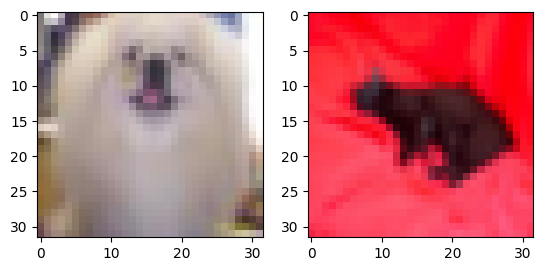

In [26]:
example_ids = np.arange(len(host_test))[:100]
example_id = np.random.choice(example_ids)

# showing host 
fig, axs = plt.subplots(ncols=2)

host_example = host_test.astype(int)[example_id]
payload_example = payload_test.astype(int)[example_id]
# payload_example = np.concatenate((payload_example, np.zeros_like(payload_example), np.zeros_like(payload_example)), axis=-1)
axs[0].imshow(host_example)
axs[1].imshow(payload_example)

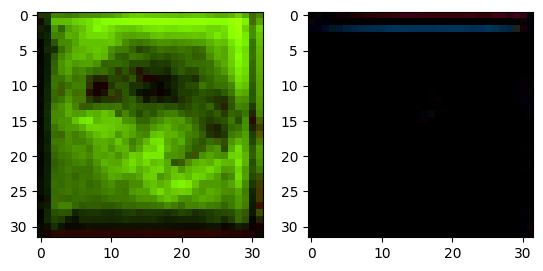

In [27]:
# showing host 
fig, axs = plt.subplots(ncols=2)

inference_dataset = tf.data.Dataset.from_tensor_slices((host_test[example_ids], payload_test[example_ids])).batch(len(example_ids))
for host, payload in inference_dataset:
    encoded_host, decoded_payload = steganography_model([host, payload])
    host_outputs = encoded_host.numpy()
    payload_output = decoded_payload.numpy()

host_output = host_outputs.astype(int)[example_id]
payload_output = payload_output.astype(int)[example_id]

    
# payload_output = np.concatenate((payload_output, np.zeros_like(payload_output), np.zeros_like(payload_output)), axis=-1)
axs[0].imshow(host_output)
axs[1].imshow(payload_output)